<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/A_11_0_2_anchor_objectness_regression_target_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

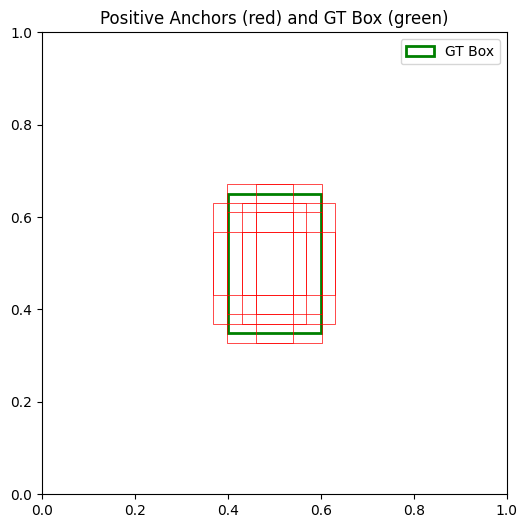

총 anchor 개수: 2304
Positive anchor 개수: 8
Negative anchor 개수: 2240
Ignored anchor 개수: 56


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Feature Map 기준 anchor 생성
def generate_anchors(feature_map_size, scales, ratios):
    fm_height, fm_width = feature_map_size
    anchors = []
    for i in range(fm_height):
        for j in range(fm_width):
            cx = (j + 0.5) / fm_width
            cy = (i + 0.5) / fm_height
            for scale in scales:
                for ratio in ratios:
                    w = scale * np.sqrt(ratio)
                    h = scale / np.sqrt(ratio)
                    anchors.append([cx, cy, w, h])
    return np.array(anchors)

# IoU 계산 함수
def compute_iou(boxes1, boxes2):
    def to_corners(box):
        cx, cy, w, h = tf.split(box, 4, axis=-1)
        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2
        return tf.concat([x1, y1, x2, y2], axis=-1)

    boxes1 = to_corners(tf.cast(boxes1, tf.float32))
    boxes2 = to_corners(tf.cast(boxes2, tf.float32))

    """
    브로드캐스팅 및 tf.maximum
    (N, 1)과 (1, M)이 만나서 브로드캐스팅 → 결과 (N, M)
    각 (i, j) 요소는 boxes1[i] 와 boxes2[j] 두 박스의 x1 좌표 중 더 큰 값
    → 두 박스가 겹치는 영역의 왼쪽 경계 좌표를 찾는 것 (겹치는 영역 시작 x 위치)
    """
    x1 = tf.maximum(boxes1[:, None, 0], boxes2[None, :, 0])
    y1 = tf.maximum(boxes1[:, None, 1], boxes2[None, :, 1])
    x2 = tf.minimum(boxes1[:, None, 2], boxes2[None, :, 2])
    y2 = tf.minimum(boxes1[:, None, 3], boxes2[None, :, 3])

    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union = area1[:, None] + area2[None, :] - intersection
    return intersection / union

# Regression 보정값 계산 함수
"""
이 함수는 앵커 박스를 기준으로 GT 박스의 상대적 위치 및 크기 차이를 계산하며,
이렇게 나온 결과값인 tx, ty, tw, th가 바로 모델이 학습할 목표값(Target)입니다.
"""
def encode_box(anchor, gt):
    a_cx, a_cy, a_w, a_h = tf.split(anchor, 4, axis=-1)
    g_cx, g_cy, g_w, g_h = tf.split(gt, 4, axis=-1)

    tx = (g_cx - a_cx) / a_w
    ty = (g_cy - a_cy) / a_h
    tw = tf.math.log(g_w / a_w)
    th = tf.math.log(g_h / a_h)
    return tf.concat([tx, ty, tw, th], axis=-1)

# 시각화 함수
def show_anchor_gt_overlap(anchor_tensor, gt_box, objectness_labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    """
    보통 바운딩 박스는 중심 좌표 (cx, cy)와 크기 (w, h)로 주어집니다.
    그런데 plt.Rectangle()은 왼쪽 아래 모서리 기준이기 때문에:
    왼쪽 아래 x = cx - w/2
    왼쪽 아래 y = cy - h/2
    """
    cx, cy, w, h = gt_box[0]
    ax.add_patch(plt.Rectangle((cx - w/2, cy - h/2), w, h,
                 fill=False, edgecolor='green', linewidth=2, label='GT Box'))

    # Positive Anchor들을 시각화하는 데 사용됩니다
    for i in range(anchor_tensor.shape[0]):
        if objectness_labels[i] == 1.0:
            cx, cy, w, h = anchor_tensor[i].numpy()
            ax.add_patch(plt.Rectangle((cx - w/2, cy - h/2), w, h,
                         fill=False, edgecolor='red', linewidth=0.5))

    ax.set_title("Positive Anchors (red) and GT Box (green)")
    plt.legend()
    plt.show()

# ----------- 실행 파트 -----------

# 설정
feature_map_size = (16, 16)
scales = [0.1, 0.2, 0.4]
ratios = [1.0, 2.0, 0.5]

# Anchor 생성
anchors = generate_anchors(feature_map_size, scales, ratios)
anchor_tensor = tf.constant(anchors, dtype=tf.float32)

# 예시 GT box
gt_box = tf.constant([[0.5, 0.5, 0.2, 0.3]], dtype=tf.float32)

# IoU 계산 및 objectness 라벨링
ious = compute_iou(anchor_tensor, gt_box)
best_iou = tf.reduce_max(ious, axis=1)
positive_mask = best_iou > 0.5
negative_mask = best_iou < 0.3

"""
1. 첫 번째 tf.where:
   positive_mask가 True인 위치에는 1.0을 대입 (Positive anchor)
   False인 위치에는 두 번째 tf.where 결과를 대입
2. 두 번째 tf.where:
   negative_mask가 True인 위치에는 0.0을 대입 (Negative anchor)
   둘 다 아니면 -1.0을 대입 (Ignore anchor)
"""
objectness_labels = tf.where(positive_mask, 1.0, tf.where(negative_mask, 0.0, -1.0))

# Regression 타겟
"""
anchor_tensor의 각 앵커 박스와,
그 앵커 개수만큼 반복된 같은 gt_box(Ground Truth 박스)들을 비교해서,
각 앵커 기준으로 GT 박스 좌표를 인코딩하는 코드입니다.
"""
# 앵커 박스를 기준으로 GT 박스의 상대적인 위치와 크기 차이를 계산
"""
모델은 앵커 박스에서 얼마나 이동하고 크기를 얼마나 조정해야 정답 박스(GT box)에 가까워지는지를 학습합니다.
이를 위해 앵커 기준으로 GT 박스를 인코딩(정규화된 차이)해서 회귀 타깃으로 사용합니다.
"""
gt_encoded = encode_box(anchor_tensor, tf.repeat(gt_box, repeats=anchor_tensor.shape[0], axis=0))


# 시각화
show_anchor_gt_overlap(anchor_tensor, gt_box, objectness_labels)

# 결과 출력
print("총 anchor 개수:", anchor_tensor.shape[0])
print("Positive anchor 개수:", tf.reduce_sum(tf.cast(objectness_labels == 1.0, tf.int32)).numpy())
print("Negative anchor 개수:", tf.reduce_sum(tf.cast(objectness_labels == 0.0, tf.int32)).numpy())
print("Ignored anchor 개수:", tf.reduce_sum(tf.cast(objectness_labels == -1.0, tf.int32)).numpy())


In [ ]:
import tensorflow as tf

# 1번째 박스 집합 면적 (N=3)
area1 = tf.constant([4, 9, 16])   # 예: 3개 박스

# 2번째 박스 집합 면적 (M=2)
area2 = tf.constant([5, 10])      # 예: 2개 박스

# 교집합 면적 (3 x 2)
intersection = tf.constant([
    [1, 2],  # box0 vs boxA, boxB
    [3, 1],  # box1 vs boxA, boxB
    [0, 4],  # box2 vs boxA, boxB
])

# 합집합 계산
"""
계산 설명 (첫 번째 값)
union[0,0] = area1[0] + area2[0] - intersection[0,0] = 4 + 5 - 1 = 8
union[0,1] = 4 + 10 - 2 = 12
union[1,0] = 9 + 5 - 3 = 11
union[1,1] = 9 + 10 - 1 = 18
union[2,0] = 16 + 5 - 0 = 21
union[2,1] = 16 + 10 - 4 = 22
"""
union = area1[:, None] + area2[None, :] - intersection

print("union shape:", union.shape)
print("union:\n", union.numpy())


union shape: (3, 2)
union:
 [[ 8 12]
 [11 18]
 [21 22]]


In [ ]:
import tensorflow as tf

gt_box = tf.constant([[50, 60, 100, 80]])   # shape (1, 4)
anchor_tensor_shape0 = 5

repeated = tf.repeat(gt_box, repeats=anchor_tensor_shape0, axis=0)
print(repeated.numpy())

# 출력:
# [[ 50  60 100  80]
#  [ 50  60 100  80]
#  [ 50  60 100  80]
#  [ 50  60 100  80]
#  [ 50  60 100  80]]


[[ 50  60 100  80]
 [ 50  60 100  80]
 [ 50  60 100  80]
 [ 50  60 100  80]
 [ 50  60 100  80]]
